In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import BertTokenizer, BertModel
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

c:\Users\IBDA\.conda\envs\ta_james_bert\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Initiate Dataset

In [3]:
# https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data
df = pd.read_excel("25k_labeling.xlsx",sheet_name="Sheet1")
df['comments'] = df['comments'].astype(str)
df['sentiment'] = df['sentiment'].astype(int)
# df = df.rename(columns={'label': 'sentiment'})
df.head()

,Unnamed: 0,comments,bank,platform,sentiment,topic
0,0,keren sekali transmart bintang melanda bintang...,Bank Mega,Instagram,0,service
1,1,tidak pernah kabari menerapkan,Bank Mega,Instagram,1,service
2,2,keren bht,Bank Mega,Instagram,0,service
3,3,transmart makssar masih kurang lengkap barangnya,Bank Mega,Instagram,2,service
4,4,dan transmart keren oke wajah tersenyum dengan...,Bank Mega,Instagram,0,service


In [4]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

## Train Validation Split

In [5]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
# Reset index for both train and validation sets
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

# Extract texts and labels
train_texts, train_labels = train_df["comments"], train_df["sentiment"]
val_texts, val_labels = val_df["comments"], val_df["sentiment"]

# BERT Model

In [6]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes, freeze_layers = 0):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes) #add classification layer
        self.freeze_layers = freeze_layers
        # print(self.bert.encoder.layer)
        # print(self.named_parameters())
        # for param in self.bert.parameters():
        #     param.requires_grad = False
        for i in range(freeze_layers):
            for name, param in self.bert.encoder.layer[i].named_parameters():
                param.requires_grad = False

        # layer_count = 0
        # for name, param in self.bert.named_parameters():
        #     print(name)
        #     if 'layer' in name:
        #         layer_count += 1
        #         if layer_count <= freeze_layers:
        #             param.requires_grad = False
        #             # print('Masuk')
        # print(layer_count)


    def forward(self, input_ids, attention_mask):
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            # # Freeze specified layers
            # if self.freeze_layers > 0:
            #     with torch.no_grad():
            #         # Detach the output of the frozen layers from the computational graph
            #         for layer in range(self.freeze_layers):
            #             outputs.hidden_states[layer] = outputs.hidden_states[layer].detach()
            last_hidden_states = outputs.last_hidden_state
            hidden_states = outputs.hidden_states
            attentions = outputs.attentions
            pooled_output = outputs.pooler_output
            x = self.dropout(pooled_output)
            logits = self.fc(x)
            # print(last_hidden_states)
            # print(hidden_states)
            # print(attentions)
            # print(pooled_output)
            # print(logits)
            return logits
    
    def print_layers(self):
        for name, param in self.named_parameters():
            print(f"Layer: {name}, Requires Gradient: {param.requires_grad}")

In [7]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    val_loss = 0.0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device).long()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())

            # Compute validation loss
            loss = F.cross_entropy(outputs, labels)
            val_loss += loss.item() * input_ids.size(0)  # Accumulate the loss
    # val_accuracy = accuracy_score(actual_labels, predictions)
    # classification_rep = classification_report(actual_labels, predictions)
    avg_val_loss = val_loss / len(data_loader.dataset)  # Compute average validation loss
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions), avg_val_loss

In [8]:
def compute_saliency_map(model, input_ids, attention_mask, label):
    print(input_ids, attention_mask, label)
    model.eval()
    grad_input_ids = torch.ones_like(input_ids, dtype=torch.float32, requires_grad=True)
    grad_attention_mask = torch.ones_like(attention_mask, dtype=torch.float32, requires_grad=True)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    loss = F.cross_entropy(outputs, label)

    model.zero_grad()

    # Compute gradients of the loss with respect to the new tensors
    loss.backward(retain_graph=True)

    # Ensure gradients are computed and accessible
    if grad_input_ids.grad is None:
        raise RuntimeError("Gradients for grad_input_ids are None. Check if gradients are being computed correctly.")

    # Compute the saliency map
    saliency_map = grad_input_ids.grad.abs().sum(dim=-1).detach().cpu().numpy()

    # Debugging: Print gradients of the model parameters after backward pass
    print("Gradients after backward pass:")
    for name, param in model.named_parameters():
        print(name, param.grad)

    return saliency_map

def visualize_saliency_maps(batch, saliency_map):
    input_text = batch['input_text']
    tokens = input_text.split()  # Assuming input_text is a single string of space-separated tokens

    # Normalize the saliency map
    saliency_map = saliency_map / np.max(saliency_map)

    # Plot the saliency map
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(tokens)), saliency_map, tick_label=tokens, color='skyblue')
    plt.xlabel('Tokens')
    plt.ylabel('Saliency Score')
    plt.title('Saliency Map')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [9]:
import torch

def train(model, train_loader, val_loader, optimizer, scheduler, device, num_epochs, patience, checkpoint_path):
    model.train()
    best_val_accuracy = 0.0
    consecutive_no_improvement = 0
    train_losses = []
    val_losses = []
    val_accuracies = []
    train_accuracies = []
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Training phase
        epoch_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
             # Compute gradients for saliency map
            # saliency_map = compute_saliency_map(model, input_ids, attention_mask, labels)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = nn.CrossEntropyLoss()(outputs, labels.long())
            # grad_input_ids = torch.ones_like(input_ids, dtype=torch.float32, requires_grad=True)
            # print(grad_input_ids)
            loss.backward(retain_graph=True)
            # print("Gradients before optimizer step:")
            # for name, param in model.named_parameters():
            #     if param.grad is not None:
            #         print(name, param.grad.mean())
            #     else:
            #         print(name, "None")

            optimizer.step()
            scheduler.step()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
            # saliency_map = grad_input_ids.grad.abs().sum(dim=-1).detach().cpu().numpy()
            # print("Gradients after optimizer step:")
            # for name, param in model.named_parameters():
            #     if param.grad is not None:
            #         print(name, param.grad.mean())
            #     else:
            #         print(name, "None")

            epoch_train_loss += loss.item()
        train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation phase
        val_accuracy, report, val_loss = evaluate(model, val_loader, device)
        print(report)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f"Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}")

        # Check for early stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            consecutive_no_improvement = 0

            # Save the checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_accuracy': best_val_accuracy,
                'consecutive_no_improvement': consecutive_no_improvement
            }, checkpoint_path)

        else:
            consecutive_no_improvement += 1

        if consecutive_no_improvement >= patience:
            print(f"Early stopping after {epoch + 1} epochs without improvement.")
            break
        #Visualize saliency maps
        # if epoch % 2 == 0:
        #     visualize_saliency_maps(batch, saliency_map)

    # Plot learning curves
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("Training completed.")

In [10]:
bert_model_name = 'indolem/indobert-base-uncased'
num_classes = 3
max_length = 128
batch_size = 16
num_epochs = 50
learning_rate = 2e-5
patience = 5
checkpoint_path = "best_indobert_model.pth"

In [11]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [12]:
torch.cuda.is_available()

True

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
freeze_layers = 1
model = BERTClassifier(bert_model_name, num_classes, freeze_layers).to(device)
print(model)

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31923, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [14]:
print(device)

cuda


In [15]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

c:\Users\IBDA\.conda\envs\ta_james_bert\Lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/50
              precision    recall  f1-score   support

           0       0.91      0.76      0.83      2084
           1       0.79      0.87      0.83      2502
           2       0.58      0.71      0.64       405

    accuracy                           0.81      4991
   macro avg       0.76      0.78      0.77      4991
weighted avg       0.82      0.81      0.81      4991

Validation Accuracy: 0.8108595471849329, Validation Loss: 0.48757715696706677
Epoch 2/50
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      2084
           1       0.84      0.85      0.84      2502
           2       0.63      0.77      0.69       405

    accuracy                           0.84      4991
   macro avg       0.79      0.82      0.80      4991
weighted avg       0.84      0.84      0.84      4991

Validation Accuracy: 0.8375075135243438, Validation Loss: 0.40866043730791
Epoch 3/50
              precision    recall  f1-score   suppor

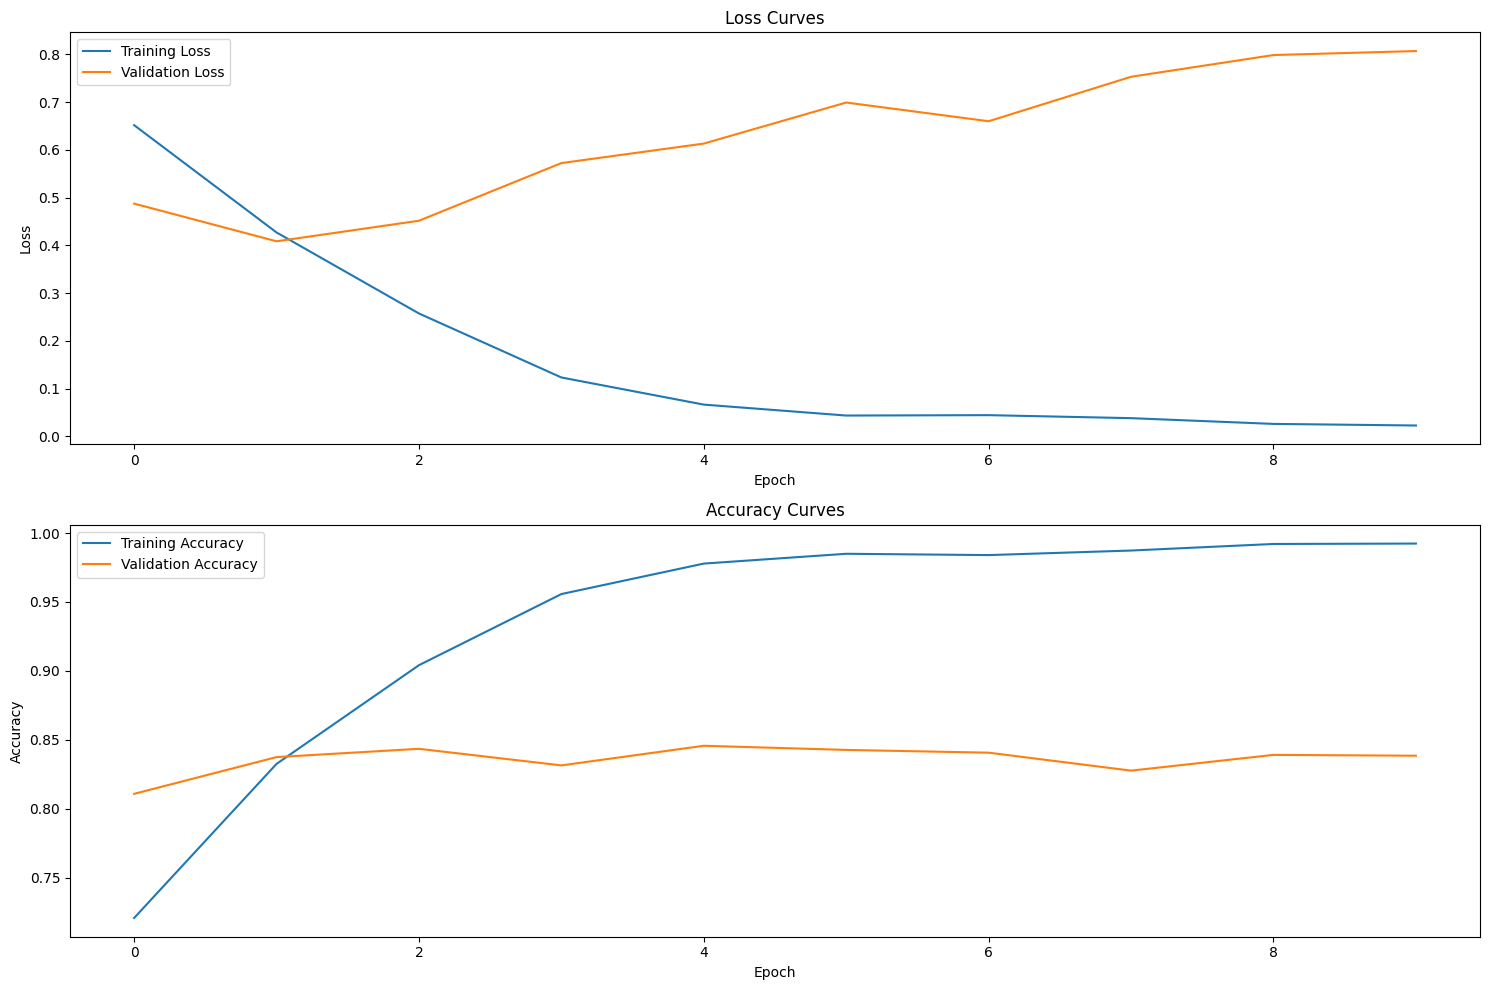

Training completed.


In [16]:
train(model, train_dataloader, val_dataloader, optimizer, scheduler, device, num_epochs, patience, checkpoint_path)

## Save model

In [17]:
torch.save(model.state_dict(), 'bert_model_0_ts020.pth')

In [18]:
# Instantiate the BERT model architecture
loaded_model = BERTClassifier(bert_model_name, num_classes)

# Load the saved model state dictionary
loaded_model.load_state_dict(torch.load('bert_model2.pth'))

# Set the model to evaluation mode (important if you have dropout layers)
loaded_model.eval()

# Move the model to the desired device (CPU or GPU)
loaded_model.to(device)

FileNotFoundError: [Errno 2] No such file or directory: 'bert_model2.pth'

## Test model

In [ ]:
def predict_sentiment(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        print(preds)
        print(preds.item())
    if preds.item() == 0:
        return "positive"
    elif preds.item() == 1:
        return "neutral"
    else:
        return "negative"

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(predict_sentiment("bank mega jelek banget pelayanannya", loaded_model, tokenizer, device))

tensor([1])
1
neutral


# Check last BERT layer

In [ ]:
last_layer_weights = model.bert.encoder.layer[-1].output.dense.weight
print(last_layer_weights)

Parameter containing:
tensor([[ 0.0689,  0.0189,  0.0165,  ...,  0.0400, -0.0020, -0.0178],
        [ 0.0153,  0.0355, -0.0269,  ..., -0.0227,  0.0060, -0.0521],
        [-0.0291, -0.0510, -0.0291,  ..., -0.0312, -0.0193, -0.0641],
        ...,
        [-0.0168, -0.0012,  0.0832,  ...,  0.0555,  0.0214, -0.0211],
        [ 0.0209,  0.0067, -0.0119,  ...,  0.0427, -0.0628, -0.0385],
        [ 0.0015,  0.0131, -0.0260,  ...,  0.0237,  0.0370, -0.0185]],
       requires_grad=True)


In [ ]:
def predict_sentiment2(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        last_hidden_states = outputs.last_hidden_state
        pooler_output = outputs.pooler_output
        hidden_states = outputs.hidden_states
        attentions = outputs.attentions
        print(last_hidden_states)
        print(pooler_output)
        print(hidden_states)
        print(attentions)
    if preds.item() == 0:
        return "positive"
    elif preds.item() == 1:
        return "neutral"
    else:
        return "negative"

In [ ]:
print(predict_sentiment2("bank mega jelek banget pelayanannya", loaded_model, tokenizer, device))

AttributeError: 'Tensor' object has no attribute 'last_hidden_state'